# Anomaly Detection on Sales and Inventory Data

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/analytics-blueprints-public/blob/main/notebooks/crisp_anomaly_detection.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_anomaly_detection.ipynb)
[![Open in Databricks](https://img.shields.io/badge/databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/analytics-blueprints-public/blob/main/notebooks/crisp_anomaly_detection.ipynb)

This notebook demonstrates how to perform naive outlier detection on sales and inventory data using z-scores. We will identify data points that are considered anomalies based on the criterion that their z-score exceeds |3.5| within time windows of sufficient size.

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "80047"
# os.environ["CONNECTOR_ID"] = "" # optional

fact_sales_table = "exp_harmonized_retailer_fact_sales"
fact_inventory_table = "exp_harmonized_retailer_fact_inventory_store"

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
import os

if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Run extra imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore

### Load the data from BigQuery

We'll load data from the `fact_sales` and `fact_inventory` tables.

In [4]:
%%load sales_df
SELECT
    DATE(date_key) AS date,
    DATE_TRUNC(DATE(date_key), MONTH) AS time_window,
    store_id,
    product_id,
    sales_quantity
FROM
    `{project}.{dataset}.{fact_sales_table}`
WHERE
    sales_quantity IS NOT NULL

In [5]:
%%load inventory_df
SELECT
    DATE(date_key) AS date,
    DATE_TRUNC(DATE(date_key), MONTH) AS time_window,
    store_id,
    product_id,
    on_hand_quantity AS inventory_quantity
FROM
    `{project}.{dataset}.{fact_inventory_table}`
WHERE
    on_hand_quantity IS NOT NULL

### Perform anomaly detection using z-scores

For each time window and product, we'll compute the z-score of `sales_quantity` and identify outliers where the absolute z-score exceeds 3.5.

In [6]:
# Function to compute z-scores and identify outliers
def detect_outliers(group):
    if len(group) > 30:
        group["z_score"] = zscore(group["sales_quantity"])
        group["outlier"] = group["z_score"].abs() > 3.5
    else:
        group["z_score"] = np.nan
        group["outlier"] = False
    return group

sales_df["sales_quantity"] = sales_df["sales_quantity"].astype(float)

# Apply the function to each product within each time window
grouped_sales = (
    sales_df.groupby(["time_window", "product_id"], as_index=False)
    .apply(detect_outliers)
    .reset_index(drop=True)
)

/var/folders/yc/tk8l4tpj03s23nsy68jphwxr0000gn/T/ipykernel_58522/3309237698.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers)


In [7]:
sales_anomalies = grouped_sales[grouped_sales["outlier"]]
sales_anomalies = (
    sales_anomalies.groupby(["product_id", "store_id", "time_window"])
    .last()
    .reset_index()
)

print(f"Number of anomalies detected in sales data: {len(sales_anomalies)}")
sales_anomalies.head()

print(f"Number of anomalies detected in sales data: {len(sales_anomalies)}")
print(f"Total number of sales data points: {len(sales_df)}")
print(
    f"Anomalies as a percentage of total sales data: {len(sales_anomalies) / len(sales_df) * 100:.2f}%"
)

Number of anomalies detected in sales data: 369457
Number of anomalies detected in sales data: 369457
Total number of sales data points: 38664499
Anomalies as a percentage of total sales data: 0.96%


### Visualize the anomalies in sales data

We can plot the sales quantities over time for a specific product and highlight the anomalies.

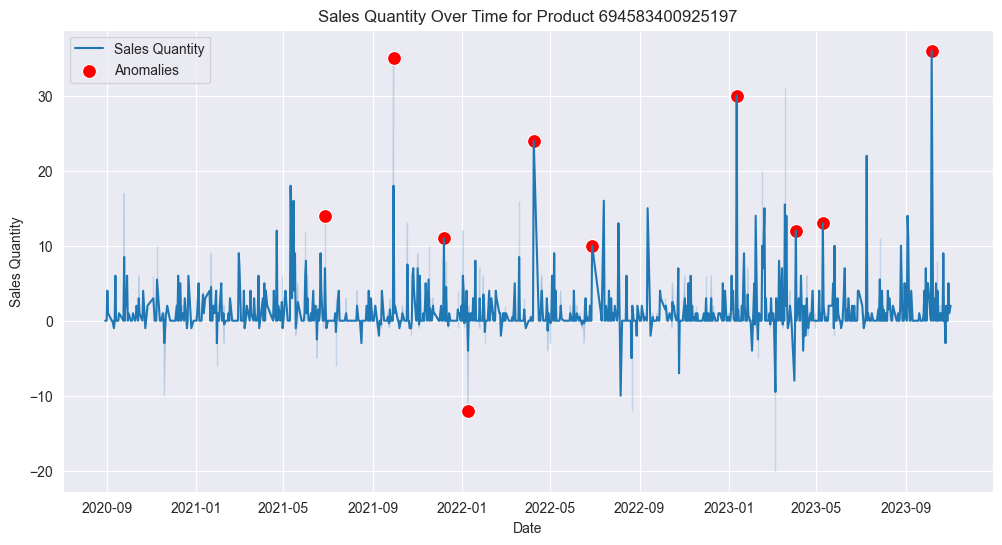

In [8]:
if not sales_anomalies.empty:
    product_to_plot = sales_anomalies["product_id"].iloc[0]
    product_data = grouped_sales[grouped_sales["product_id"] == product_to_plot].copy()

    # Ensure 'outlier' is boolean
    product_data["outlier"] = product_data["outlier"].astype(bool)

    # Plot sales quantity over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=product_data, x="date", y="sales_quantity", label="Sales Quantity"
    )

    # Plot anomalies
    anomalies = product_data[product_data["outlier"]]
    sns.scatterplot(
        data=anomalies,
        x="date",
        y="sales_quantity",
        color="red",
        label="Anomalies",
        s=100,
    )
    plt.title(f"Sales Quantity Over Time for Product {product_to_plot}")
    plt.xlabel("Date")
    plt.ylabel("Sales Quantity")
    plt.legend()
    plt.show()
else:
    print("No anomalies detected to visualize.")

### Perform anomaly detection on inventory data (if needed)

You can apply the same process to the inventory data.

In [9]:
# Function to compute z-scores and identify outliers
def detect_outliers_inventory(group):
    if len(group) > 30:
        group["z_score"] = zscore(group["inventory_quantity"])
        group["outlier"] = group["z_score"].abs() > 3.5
    else:
        group["z_score"] = np.nan
        group["outlier"] = False
    return group

inventory_df["inventory_quantity"] = inventory_df["inventory_quantity"].astype(float)

# Apply the function to each product within each time window
grouped_inventory = (
    inventory_df.groupby(["time_window", "product_id"], as_index=False)
    .apply(detect_outliers_inventory)
    .reset_index(drop=True)
)

/var/folders/yc/tk8l4tpj03s23nsy68jphwxr0000gn/T/ipykernel_58522/4262558697.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers_inventory)


### Examine the anomalies in inventory data

In [10]:
inventory_anomalies = grouped_inventory[grouped_inventory["outlier"]]
inventory_anomalies = (
    inventory_anomalies.groupby(["product_id", "store_id", "time_window"])
    .last()
    .reset_index()
)

print(f"Number of anomalies detected in inventory data: {len(inventory_anomalies)}")
inventory_anomalies.head()

print(f"Number of anomalies detected in inventory data: {len(inventory_anomalies)}")
print(f"Total number of inventory data points: {len(inventory_df)}")
print(
    f"Anomalies as a percentage of total inventory data: {len(inventory_anomalies) / len(inventory_df) * 100:.2f}%"
)

Number of anomalies detected in inventory data: 27877
Number of anomalies detected in inventory data: 27877
Total number of inventory data points: 57300191
Anomalies as a percentage of total inventory data: 0.05%


### Visualize the anomalies in inventory data

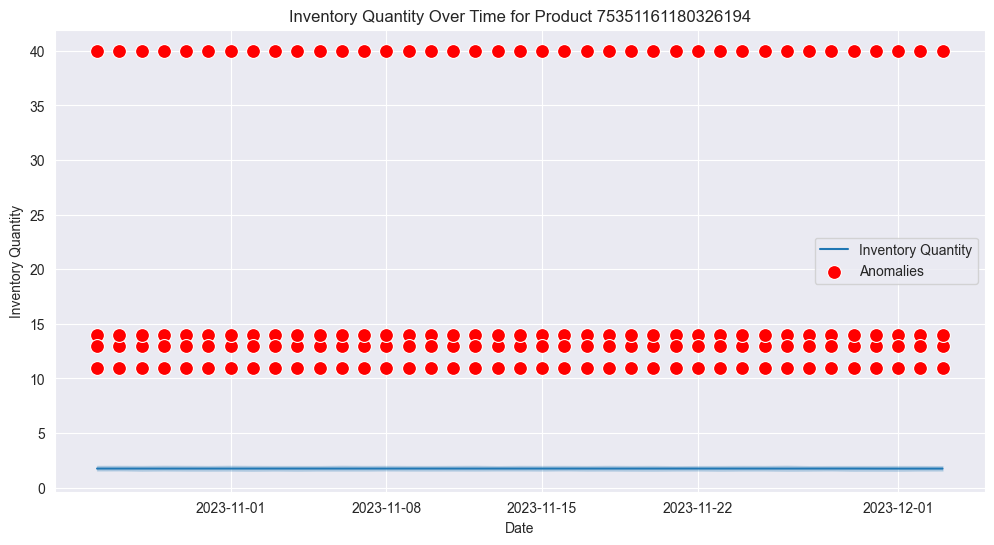

In [11]:
# Choose a product to visualize
if not inventory_anomalies.empty:
    product_to_plot = inventory_anomalies["product_id"].iloc[0]
    product_data = grouped_inventory[
        grouped_inventory["product_id"] == product_to_plot
    ].copy()

    # Ensure 'outlier' is a boolean
    product_data["outlier"] = product_data["outlier"].astype(bool)

    # Plot inventory quantity over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=product_data, x="date", y="inventory_quantity", label="Inventory Quantity"
    )

    # Plot anomalies
    anomalies = product_data[product_data["outlier"]]
    # Add hover tooltip to red dots that has store_id
    sns.scatterplot(
        data=anomalies,
        x="date",
        y="inventory_quantity",
        color="red",
        label="Anomalies",
        s=100,
    )

    plt.title(f"Inventory Quantity Over Time for Product {product_to_plot}")
    plt.xlabel("Date")
    plt.ylabel("Inventory Quantity")
    plt.legend()
    plt.show()
else:
    print("No anomalies detected to visualize.")

### Save or report the anomalies

#### Save anomalies to CSV files

In [12]:
# Save sales anomalies to a CSV file
sales_anomalies.to_csv("sales_anomalies.csv", index=False)
print("Sales anomalies saved to 'sales_anomalies.csv'.")

# Save inventory anomalies to a CSV file
inventory_anomalies.to_csv("inventory_anomalies.csv", index=False)
print("Inventory anomalies saved to 'inventory_anomalies.csv'.")

Sales anomalies saved to 'sales_anomalies.csv'.
Inventory anomalies saved to 'inventory_anomalies.csv'.


#### Save anomalies to your data warehouse

In [13]:
sales_anomalies

,product_id,store_id,time_window,date,sales_quantity,z_score,outlier
0,694583400925197,43897245528978849,2022-01-01,2022-01-09,-12.0,-3.920297,True
1,694583400925197,7455363607872497698,2021-06-01,2021-06-27,14.0,4.053127,True
2,694583400925197,7455363607872497698,2021-09-01,2021-09-29,35.0,5.563950,True
3,694583400925197,7455363607872497698,2021-12-01,2021-12-07,11.0,4.194140,True
4,694583400925197,7455363607872497698,2022-04-01,2022-04-09,24.0,5.050883,True
...,...,...,...,...,...,...,...
369452,9218209562277089463,8910870284304508627,2023-09-01,2023-09-18,4.0,3.845485,True
369453,9218209562277089463,8926890317301298570,2023-08-01,2023-08-27,6.0,6.404691,True
369454,9218209562277089463,8938153192156326512,2023-09-01,2023-09-17,4.0,3.845485,True
369455,9218209562277089463,9201012415016624068,2023-08-01,2023-08-26,4.0,3.645114,True


In [14]:
%%save {project}.{dataset}.sales_anomalies
sales_anomalies

In [15]:
inventory_anomalies

,product_id,store_id,time_window,date,inventory_quantity,z_score,outlier
0,75351161180326194,3219627019937845776,2023-10-01,2023-10-29,13.0,4.704457,True
1,75351161180326194,3219627019937845776,2023-11-01,2023-11-28,13.0,4.704430,True
2,75351161180326194,3219627019937845776,2023-12-01,2023-12-02,13.0,4.703663,True
3,75351161180326194,3645452380602234202,2023-10-01,2023-10-27,14.0,5.122612,True
4,75351161180326194,3645452380602234202,2023-11-01,2023-11-05,14.0,5.122578,True
...,...,...,...,...,...,...,...
27872,9212139262863234961,8520901116193434983,2023-11-01,2023-11-08,19.0,4.041777,True
27873,9212139262863234961,8520901116193434983,2023-12-01,2023-12-03,19.0,4.530177,True
27874,9212139262863234961,8710151477965104692,2023-10-01,2023-10-27,59.0,3.711614,True
27875,9212139262863234961,8844127078768378814,2023-10-01,2023-10-26,65.0,4.156154,True


In [16]:
%%save {project}.{dataset}.inventory_anomalies
inventory_anomalies